# Figure 1
- This experiment tests whether the fish HD neurons can track visaul scenes.
- The experiment starts with repeated presentations of flashes, followed by the presentation of the "sun-and-bars" scene, as well as darkness.
- This notebook generates all data panels in **Fig. 1** and **Extended Data Fig. 2** as well as some panels in **Extended Data Fig. 1, 3**.
    - Panels are not in the order due to some shuffling during the editorial process -- sorry!
- Note that the results of bootstrap tests can very mildly fluctuate by the random number generator seed, which we did not fix in the reviewed version. The conclusions of all the analysis are robust to this fluctuation. 

In [1]:
# Import packages
from utility import *
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from scipy.stats import binned_statistic, kstest, uniform
from scipy.signal import convolve2d
import json
import colorcet as cc

C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# configure matplotlib
config_rcparams()

In [3]:
# parameters
R2_thresh = 0.15   # for finding cells whose activity can be well fit by sinusoids of the scene orientation
flash_thresh = 0.1 # for rejecting light responsive cells
n_heading_bin = 8  # we average HD neuron activity within 8 evenly spaced preferred orientaiton bins
n_bootstrap = 1000 # number of shuffles for bootstrap tests
mask_name = 'rhombomere1'

In [4]:
# get a list of fish
data_path = '../data/main01'
fish_list = get_fish_list(data_path, silent=True)

# because in this experiment we made multiple recordings from a single fish, we need
# a nested analysis
nested_list = nest_fish_list_per_fish(fish_list)

# Analysis
## Data extraction and ROI selection
- loop through the recordings, load data
- register relevant behavioral/physiological data into dict

In [5]:
data = []

# Go through all unique fish
for fish_id, recording_list in enumerate(nested_list):
    data.append([])
    
    # Go through all recordings from the given fish
    for recording in recording_list:
        
        # get zoom factor, for anatomical visualization
        with open(recording / 'scandata.json', 'r') as f:
            zoom = json.load(f)['magnification']
        
        # Load Mask -- trust whichever the latest, in case multiple attempts to draw masks were made
        mask_list = list(recording.glob('mask_'+mask_name+'*'))
        with open(mask_list[-1], 'r') as f:
            mask = json.load(f)
        
        #################
        ### Load data ###
        #################
        
        # custom utility to load imaging & behavioral data
        s2p_data, t_i, exp = load_data(recording, cells_only=False)

        # Get the coordinates of ROIs, because we do some anatomical visualization
        roi_coords = s2p_data['coords']

        # This is a list of dicts, each corresponding to different stimulus epochs
        slog = exp['stimulus']['log']

        # timestamp for stimuli
        t_s = exp.stimulus_log['t'].to_numpy()

        # time traces of the scene angle theta
        theta = exp.stimulus_log['cl2D_theta'].to_numpy()

        # Here we recover the self-generated (cumftheta) and external (extheta) components of the scene rotations
        gtheta = exp.stimulus_log['cl2D_goal_theta'].to_numpy()
        ftheta = exp.stimulus_log['cl2D_fish_theta'].to_numpy() * exp.stimulus_log['cl2D_start_theta_update'].to_numpy()
        ftheta[np.isnan(ftheta)] = 0

        # downsample stimulus data to imaging frame rate
        theta_i = downsample_traces(t_s, theta, t_i)
        cumftheta_i = downsample_traces(t_s, np.cumsum(ftheta), t_i)
        extheta_i = downsample_traces(t_s, gtheta+np.cumsum(ftheta), t_i)
        
        # restrict Rois by mask 
        # doing this before functional selection to reduce the time-consuming nonlinear curve fitting
        in_mask = (roi_coords[:, 2] > mask['x0']) * (roi_coords[:, 2] < mask['x1']) * (roi_coords[:, 1] > mask['y0']) * (roi_coords[:, 1] < mask['y1'])
        traces = s2p_data['traces'][in_mask,:len(t_i)]
        roi_coords = roi_coords[in_mask, :]
        n_roi = traces.shape[0]
        
        # Z-scoring and smoothing
        norm_traces = ((traces.T - np.median(traces, axis=1))/np.std(traces, axis=1)).T
        smoothed_traces = convolve2d(norm_traces, np.ones((1,5))/5, mode='same')
        
        #####################
        ### ROI selection ###
        #####################
        
        # Reject ROIs that exhibited consistent response to flash ON/OFF
        flash_duration = slog[1]['duration']*2
        flash_t_start = [epoch['t_start'] for epoch in slog[1:-2:2]] # first epoch is wait, last two epochs are sun-and-bars and darkness. 
        flash_corr = calc_snip_correlation(norm_traces, t_i, flash_t_start, flash_duration)
        
        # Sinusoidal regression -- only use the second half for cross validation
        is_valid_theta = (np.isnan(theta_i)==False) * split_time(t_i, slog[-2]['t_start'], slog[-2]['duration'])
        fit_param, _, R2 = fit_transform_sinusoid(smoothed_traces[:, is_valid_theta], theta_i[is_valid_theta])
        
        # do the selection
        good_fit = (R2 > R2_thresh) * (flash_corr < flash_thresh)
        print(recording, 'Found', np.sum(good_fit), 'good ROIs out of', n_roi )
        
        # metadata for variability analysis
        metadata_dict = {'age': exp['general']['animal']['age'],
                         'n_roi_tot':traces.shape[0],
                         'hour':int(exp['general']['t_protocol_start'][11:13]),
                         'n_bout_tot':len(np.where(exp.stimulus_log['cl2D_start_theta_update'])[0])}
        
        ### Save everything in a dictionary ###
        D = {'stack': s2p_data['anatomy_stack'][0,:,:],
             'slog': slog,
             't_s': t_s,
             't_b': exp.behavior_log['t'].to_numpy(),
             'fish_theta': exp.stimulus_log['cl2D_fish_theta'].to_numpy(),
             'theta_update_spike': exp.stimulus_log['cl2D_start_theta_update'].to_numpy(),
             'tail_sum': exp.behavior_log['tail_sum'].to_numpy(),
             't_i': t_i,
             'theta_i': theta_i,
             'cumftheta_i': cumftheta_i,
             'extheta_i': extheta_i,
             'traces': smoothed_traces[good_fit, :],
             'fit_param': fit_param[good_fit,:],
             'coords': roi_coords[good_fit, :],
             'R2' : R2[good_fit],
             'selection_criteria': (R2, fit_param, flash_corr),
             'zoom': zoom,
             'metadata': metadata_dict}

        data[-1].append(D)

..\data\main01\20230825_f1_p0 Found 48 good ROIs out of 221
..\data\main01\20230825_f1_p1 Found 96 good ROIs out of 299
..\data\main01\20230825_f1_p2 Found 48 good ROIs out of 519
..\data\main01\20230825_f2_p0 Found 41 good ROIs out of 285
..\data\main01\20230825_f2_p1 Found 51 good ROIs out of 296
..\data\main01\20230825_f3_p0_copy Found 34 good ROIs out of 298
..\data\main01\20230825_f4_p0 Found 58 good ROIs out of 267
..\data\main01\20230825_f4_p1 Found 32 good ROIs out of 607
..\data\main01\20231018_f0_p0_4d Found 25 good ROIs out of 110
..\data\main01\20231018_f1_p0_v04d Found 18 good ROIs out of 117
..\data\main01\20231025_f2_gad_actuallyahb Found 27 good ROIs out of 97
..\data\main01\20231026_f0_86_4d Found 45 good ROIs out of 100
..\data\main01\20231026_f3_4d_copy Found 27 good ROIs out of 108
..\data\main01\20231026_f4_4d Found 18 good ROIs out of 199
..\data\main01\20231105_f0_gad1b_aHB_z182_v4d Found 7 good ROIs out of 108
..\data\main01\20231105_f1_gad1b_aHB_z155_4d Found 6

## Additional preprocessing
- Calculate the bump phae (population vector average, PVA) for each recording
- Calculate the anatomical mid-point of the ROIs

In [6]:
for i, fish_data in enumerate(data):
    for j, D in enumerate(fish_data):
        
        # PVA (bump phase) calculation
        pva_theta, pva_length, binned_traces, _, _ = calc_binned_pva(D['traces'], D['fit_param'][:,1], n_bin=n_heading_bin)
        data[i][j]['pva_theta'] = pva_theta
        data[i][j]['pva_length'] = pva_length
        data[i][j]['binned_traces'] = binned_traces
        
        # anatomical range calculation
        if len(D['coords'])>0:
            midx = (np.max(D['coords'][:,2]) + np.min(D['coords'][:,2])) / 2
            midy = (np.max(D['coords'][:,1]) + np.min(D['coords'][:,1])) / 2
        else:
            midx = midy = 0
        
        data[i][j]['midx'] = midx
        data[i][j]['midy'] = midy

- Flag recording with less than 5 bins filled

In [7]:
# This is not being happend, because just it so happened that I don't have such fish in this particular dataset
good_rec_flag = []
for i, fish_data in enumerate(data):
    temp = []
    for j, D in enumerate(fish_data):
        n_empty_bin = np.sum(np.isnan(data[i][j]['binned_traces'][:, 0]))
        temp.append(n_empty_bin < 5)
    good_rec_flag.append(temp)

## Bootstrap testing
- Calculate absolute error (AE), which is the absolute (ciruclar) difference between the bump phase and scene orientation
- Average AE over time, only for the test potion of the time trace (i.e., not used for the sinusoidal fitting)
- Time-domain shuffle the scene orientation time trace relative to the neural data, recalculate AE for 1,000 times
- Estimate the p-value as the fraction of true AE higher than the distribution of shuffle AE

In [8]:
AE = [] # true AE
p_AE_bs = [] # p valeu = P{AE>AEbs}
AE_bs_5pt = [] # 95 percentile to show p=0.05 points
AE_bs_med = []

# go through the fish
for i, fish_data in enumerate(data):
    
    fish_AE = []
    fish_p_AE_bs = []
    fish_AE_bs_5pt = []
    fish_AE_bs_med = []

    # go through the recordings
    for j, D in enumerate(fish_data):
        
        # perform this test only on the test set (i.e., not used for fitting)
        is_test = split_time(D['t_i'] , D['slog'][-2]['t_start'] , D['slog'][-2]['duration'], False)

        # True absolute error - angular_diff auto-wraps the range into [-pi, pi)
        rec_AE = np.mean(np.abs(angular_diff(D['pva_theta'] , D['theta_i'])[is_test]))
        rec_AE_bs = []

        # bootstrap recalculation
        for b in tqdm(range(n_bootstrap)):
            amount_shift = np.random.randint(np.sum(is_test)) # in frames, max being the duration of the test set
            test_set_pvat  = D['pva_theta'][is_test]
            test_set_theta = D['theta_i'][is_test]
            shifted_offset = angular_diff(np.roll(test_set_pvat, amount_shift), test_set_theta)
            rec_AE_bs.append(np.mean(np.abs(shifted_offset)))

        # register data
        fish_AE.append(rec_AE)
        fish_p_AE_bs.append(np.mean(rec_AE>rec_AE_bs))
        fish_AE_bs_5pt.append(np.percentile(rec_AE_bs, 5))
        fish_AE_bs_med.append(np.median(rec_AE_bs))

    # register data
    AE.append(np.asarray(fish_AE))
    p_AE_bs.append(np.asarray(fish_p_AE_bs))
    AE_bs_5pt.append(np.asarray(fish_AE_bs_5pt))
    AE_bs_med.append(np.asarray(fish_AE_bs_med))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 8327.88it/s]


# Panels
## Fig. 1c (examples of HD neurons with sinusoidal fit)

In [23]:
# IDs of fish/recording to show
fid = 1
rid = 1
n_rois_to_plot = 4

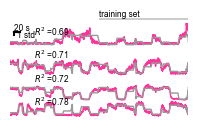

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(2.3, 1.4))
spacing = 6
D = data[fid][rid]

# find rois with evenly spaced preferred angles with highest R2
angle_bins = np.linspace(-np.pi, np.pi, n_rois_to_plot+1)

# show traces
for i in range(n_rois_to_plot):
    in_bin = (D['fit_param'][:, 1] > angle_bins[i]) * (D['fit_param'][:, 1] < angle_bins[i+1])    
    this_id = np.argmax(D['R2'] * in_bin)
    ax.plot(D['t_i'], -i*spacing + D['traces'][this_id, :], color=color_getter(0))
    ax.plot(D['t_i'], -i*spacing + scaled_shifted_cos(D['theta_i'], *D['fit_param'][this_id, :]), color=color_getter(1))
    ax.text(170, 2-i*spacing, r'$R^{2}$ ='+'{0:0.2f}'.format(D['R2'][this_id]))

# indicate training vs. test potion of the data
t_start = D['slog'][-2]['t_start']
t_end   = D['slog'][-1]['t_start']
t_train_start = t_start + (t_end-t_start)/2
ax.fill_between((t_train_start, t_end), (spacing, spacing), (spacing+0.5, spacing+0.5),  facecolor=(0.8,0.8,0.8), edgecolor='none')
ax.text(t_train_start, spacing+1, 'training set')
    
ax.plot((100,120), (3,3), 'k-', lw=1.5)
ax.text(100, 3.5, '20 s')
ax.plot((100,100), (3,2), 'k-', lw=1.5)
ax.text(110, 1.5, '1 std')
    
ax.set_xlim(D['slog'][-2]['t_start'], D['slog'][-1]['t_start'])
toggle_spines(ax, 0, 0, 0, 0)


plt.savefig('../svg/main01_c.svg')
plt.show()

## Fig. 1d (binned HD neuron activity)
- Plot $\Delta$F/F heat map
- Overlay $\theta$ and bump phase
- Show associated tail traces
- Show exogenous scene rotation

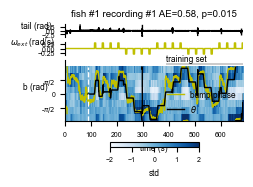

In [25]:
fig, ax = plt.subplots(3, 1, figsize=(2.3, 1.8), height_ratios=(1,1,5))

## Behavioral time trace
ax[0].plot(D['t_b'], D['tail_sum'], label='tail sum', lw=1, color='black')
ax[0].set_title('fish #{0} recording #{1} AE={2:0.2f}, p={3:0.3f}'.format(fid,rid,AE[fid][rid],p_AE_bs[fid][rid]))
ax[0].set_ylabel('tail (rad)', rotation=0)
toggle_spines(ax[0],0,0,0,1)

## visualize external rotation
OL_on = (((D['t_i']-t_start)%30)>25) * (D['t_i']>t_start) * (D['t_i']<t_end)
OL_sign = 1-2*(((D['t_i']-t_start)%240)>120)
ax[1].plot(D['t_i'], OL_on*OL_sign*18/180*np.pi,'y-')
ax[1].set_ylabel(r'$\omega_{ext}$ (rad/s)', rotation=0)
toggle_spines(ax[1],0,0,0,1)

## Neural time trace
im = ax[2].imshow(D['binned_traces'][::-1, :], aspect='auto', interpolation='nearest', vmax=2, vmin=-2, extent=(0, max(D['t_i']), -np.pi, np.pi), cmap='Blues')
ax[2].plot(D['t_i'], wrapped(np.unwrap(D['pva_theta']), offset=np.pi), 'y-', linewidth=1, label='bump phase')
ax[2].plot(D['t_i'], wrapped(D['theta_i'], offset=np.pi), 'k-', linewidth=1, label=r'$\theta$')
ax[2].plot((t_start,t_start),(-np.pi,np.pi),'w--')
ax[2].fill_between((t_train_start, t_end), (np.pi+0.2, np.pi+0.2), (np.pi+0.4, np.pi+0.4), facecolor=(0.8,0.8,0.8), edgecolor='none')
ax[2].text(t_train_start, np.pi+0.6, 'training set')
ax[2].legend()

ax[2].set_yticks([-np.pi/2, 0, np.pi/2])
ax[2].set_yticklabels((r'-$\pi/2$', '0', r'$\pi/2$'))
ax[2].set_ylabel('b (rad)', rotation=0)
ax[2].set_xlabel('time (s)')
cb = plt.colorbar(im, ax=ax, shrink=0.5, location='bottom')
cb.set_label('std')

toggle_spines(ax[2],0,1,0,1)
for axx in ax:
    axx.set_xlim(0, t_end)

plt.savefig('../svg/main01_d.svg')
plt.show()

## Fig. 1e (bootstrap test)
- Plot data AE and boostrap distribution for each recording

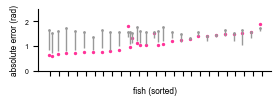

In [26]:
fig, ax = plt.subplots(figsize=(3.0,0.8))

# sort fish by mean AE
fish_sort_ind = np.argsort([np.min(temp) for temp in AE])

# go over recording and plot
for j, i in enumerate(fish_sort_ind):
    n_rec = len(AE[i])
    x_spread = np.linspace(-0.2, 0.2, n_rec)
    ax.scatter(x_spread+j, AE[i], s=2, color=color_getter(0))
    ax.errorbar(x_spread+j, AE_bs_med[i], np.vstack((AE_bs_med[i]-AE_bs_5pt[i], 0*AE_bs_med[i])),
               marker='.', markersize=2, color=color_getter(1), linestyle='none')

# axis management
ax.set_xticks(np.arange(len(AE)))
ax.set_xticklabels([])
ax.set_ylim([0, 2.5])
ax.set_xlabel('fish (sorted)')
ax.set_ylabel('absolute error (rad)')
toggle_spines(ax, 0, 1, 0, 1)

plt.savefig('../svg/main01_e.svg')
plt.show()

## Fig. 1f (preferred orientation over anatomy)
- Note that, the top left is the same recording as the example traces

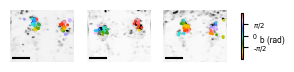

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(3.5, 1.0))

# define recordings to show
ids = ((1,1),  (2,0), (3,0))

k = 0
for i in range(3):
    D = data[ids[i][0]][ids[i][1]] 

    # note that, because of the way imaging software is written, the anatomy stack needs to be rotated and flipped
    # so that top is anterior and left is left.
    scaled_imshow(np.fliplr(np.rot90(D['stack'])), ax[k], cmap='gray_r')
    sc = ax[k].scatter(D['stack'].shape[0] - D['coords'][:,1],D['stack'].shape[1] - D['coords'][:,2], c=D['fit_param'][:,1], s=1,  cmap=cc.cm.CET_C6, vmin=-np.pi, vmax=np.pi)
    ax[k].axis('off')
    
    # scale bar
    um_per_px = 500 / D['zoom'] / D['stack'].shape[1]
    ax[k].plot((30, 30+50/um_per_px),(450, 450),'k-',lw=1.5)
    
    k += 1
        
cb = plt.colorbar(sc, ax=ax, shrink=0.6, location='right')
cb.set_label('b (rad)', rotation=0)
cb.set_ticks([-np.pi/2, 0, np.pi/2])
cb.set_ticklabels((r'-$\pi/2$', '0', r'$\pi/2$'))

plt.savefig('../svg/main01_f.svg')
plt.show()

## Extended Data Fig. 2a ($R^2$ distribution)
- Show the same fish as in the Main Fig 1, and also population

C:\Users\ryosuke\AppData\Local\Temp\ipykernel_12900\531474279.py:25: RuntimeWarning: divide by zero encountered in log10
  im = ax[1].imshow(np.log10(H.T), extent=(xbe[0], xbe[-1], ybe[-1], ybe[0]), cmap=cc.cm.CET_L19, vmin=0, vmax=3, aspect='auto')


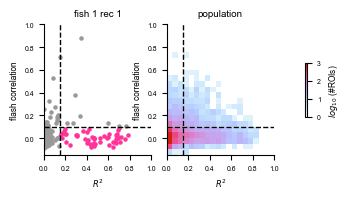

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(3.4, 1.7), width_ratios=(3,3,0.5))

# For the example fish
# Use the fid/rid are defined earlier
D = data[fid][rid]
R2, _, flash_corr = D['selection_criteria']
good_roi = (R2>R2_thresh)*(flash_corr<flash_thresh)

# For the whole population (heatmap)
all_R2 = []
all_flash_corr = []
for rec in data:
    for D in rec:
        this_R2, _, this_flash_corr = D['selection_criteria']
        all_R2.extend(this_R2)
        all_flash_corr.extend(this_flash_corr)
H, xbe, ybe = np.histogram2d(all_R2, all_flash_corr, bins=np.arange(-0.15, 1.05, 0.05))

# Single fish
ax[0].scatter(R2[good_roi], flash_corr[good_roi], s=5, color=color_getter(0))
ax[0].scatter(R2[~good_roi], flash_corr[~good_roi], s=5, color=color_getter(1))
ax[0].set_title('fish {} rec {}'.format(fid, rid))

# Population
im = ax[1].imshow(np.log10(H.T), extent=(xbe[0], xbe[-1], ybe[-1], ybe[0]), cmap=cc.cm.CET_L19, vmin=0, vmax=3, aspect='auto')
ax[1].plot((0,1), (flash_thresh, flash_thresh), 'w--')
ax[1].plot((R2_thresh, R2_thresh), (-0.15,1), 'w--')
ax[1].set_title('population')
ax[1].invert_yaxis()

ax[2].axis('off')
cb = plt.colorbar(im, ax=ax[2], location='right')
cb.set_label('$log_{10}$ (#ROIs)')

for axx in ax[:2]:
    axx.plot((0,1), (flash_thresh, flash_thresh), 'k--')
    axx.plot((R2_thresh, R2_thresh), (-0.15,1), 'k--')
    toggle_spines(axx,0,1,0,1)
    axx.set_xlim(0,1)
    axx.set_ylim(-0.15,1)
    axx.set_xlabel('$R^{2}$')
    axx.set_ylabel('flash correlation')

plt.savefig('../svg/ed02_a.svg')
plt.show()

## Extended Data Fig. 2d (more individual fish example)

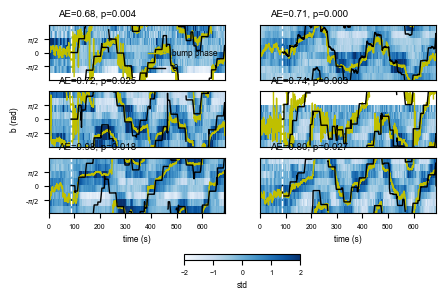

In [31]:
ids = ((6,0), (22,0), (2,0), (8,0), (0,1), (7,0))

fig, ax = plt.subplots(3, 2, figsize=(5, 3.5))

# put data
k = 0
for fid, rid in ids:
    D = data[fid][rid]
    im = ax[k//2, k%2].imshow(D['binned_traces'][::-1, :], aspect='auto', interpolation='nearest', vmax=2, vmin=-2, extent=(0, max(D['t_i']), -np.pi, np.pi), cmap='Blues')
    ax[k//2, k%2].plot(D['t_i'], wrapped(np.unwrap(D['pva_theta']), offset=np.pi), 'y-', linewidth=1, label='bump phase')
    ax[k//2, k%2].plot(D['t_i'], wrapped(D['theta_i'], offset=np.pi), 'k-', linewidth=1, label=r'$\theta$')
    ax[k//2, k%2].set_title('AE={:0.2f}, p={:0.3f}'.format(AE[fid][rid],p_AE_bs[fid][rid]), horizontalalignment='right')
    k = k + 1
cb = plt.colorbar(im, ax=ax, shrink=0.3, location='bottom')
cb.set_label('std')
ax[0,0].legend()

# cosmetics
for row, ax_row in enumerate(ax):
    for col, axx in enumerate(ax_row):
        axx.set_xlim(0, t_end)
        axx.plot((t_start,t_start),(-np.pi,np.pi),'w--')
        if row<2:
            axx.set_xticks([])
        else:
            axx.set_xlabel('time (s)')
        if col>0:
            axx.set_yticks([])
        else:
            axx.set_yticks([-np.pi/2, 0, np.pi/2])
            axx.set_yticklabels((r'-$\pi/2$', '0', r'$\pi/2$'))
            if row==ax.shape[0]//2:
                axx.set_ylabel('b (rad)')

plt.savefig('../svg/ed02_d.svg')
plt.show()

## Extended Data Fig. 2f (mean preferred scene orientaiton on left/right hemispheres)
- Do this by recording and color by p value

In [32]:
# calculate the mean (in circular fashion)
mean_b = []
for i, fish_data in enumerate(data):
    fish_mean_b = []

    for j, D in enumerate(fish_data):
        l_b = D['fit_param'][D['coords'][:,1]>D['midy'], 1]
        r_b = D['fit_param'][D['coords'][:,1]<D['midy'], 1]
        
        mean_l_b = np.arctan2(*np.mean((np.sin(l_b), np.cos(l_b)), axis=1))
        mean_r_b = np.arctan2(*np.mean((np.sin(r_b), np.cos(r_b)), axis=1))
    
        fish_mean_b.append((mean_l_b, mean_r_b))
    mean_b.append(fish_mean_b)

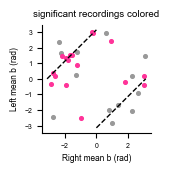

In [33]:
fig, ax = plt.subplots(1,1,figsize=(1.4, 1.4))

# scatter plot
for fish_p, fish_b in zip(p_AE_bs, mean_b):
    for p, b in zip(fish_p, fish_b):
        ax.scatter(*b, color=color_getter(int(p>0.05)), s=7)

# dotted line indicates left-right difference = pi
plt.plot((-np.pi,0), (0,np.pi), 'k--')
plt.plot((0 ,np.pi), (-np.pi,0), 'k--')

ax.set_xlabel('Right mean b (rad)')
ax.set_ylabel('Left mean b (rad)')
toggle_spines(ax, 0, 1, 0, 1)
ax.set_title('significant recordings colored')

plt.savefig('../svg/ed02_f.svg')
plt.show()

## Extended Data Fig. 3a (examples of motor-driven bump movements in the dark)

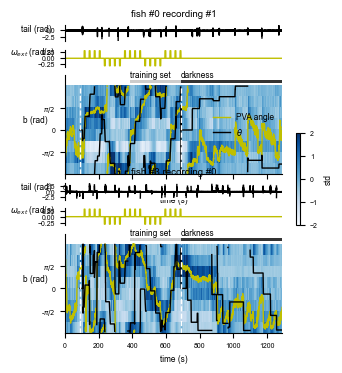

In [34]:
fig, ax = plt.subplots(6, 1, figsize=(3.5,4), height_ratios=(1,1,6, 1,1,6))

# selected recordings where we can see this
ids = ((0,1), (3,0))

k = 0
for fid, rid in ids:
    D = data[fid][rid]

    ## Behavioral time trace
    ax[k].plot(D['t_b'], D['tail_sum'], label='tail sum', lw=1, color='black')
    ax[k].set_title('fish #{0} recording #{1}'.format(fid,rid))
    ax[k].set_ylabel('tail (rad)',rotation=0)
    toggle_spines(ax[k],0,0,0,1)
    
    ## visualize external rotation
    OL_on = (((D['t_i']-t_start)%30)>25) * (D['t_i']>t_start) * (D['t_i']<t_end)
    OL_sign = 1-2*(((D['t_i']-t_start)%240)>120)
    ax[k+1].plot(D['t_i'], OL_on*OL_sign*18/180*np.pi,'y-')
    ax[k+1].set_ylabel(r'$\omega_{ext}$ (rad/s)', rotation=0)
    toggle_spines(ax[k+1],0,0,0,1)
    
    ## Neural time trace
    t_start = D['slog'][-2]['t_start']
    t_end   = D['slog'][-1]['t_start']
    t_train_start = t_start + (t_end-t_start)/2
    t_dark_end   = max(D['t_i'])
    
    im = ax[k+2].imshow(D['binned_traces'][::-1, :], aspect='auto', interpolation='nearest', vmax=2, vmin=-2, extent=(0, max(D['t_i']), -np.pi, np.pi), cmap='Blues')
    ax[k+2].plot(D['t_i'], wrapped(np.unwrap(D['pva_theta']), offset=np.pi), 'y-', linewidth=1, label='PVA angle')
    ax[k+2].plot(D['t_i'], wrapped(D['theta_i'], offset=np.pi), 'k-', linewidth=1, label=r'$\theta$')

    # epoch borders
    ax[k+2].plot((t_start,t_start),(-np.pi,np.pi),'w--')
    ax[k+2].plot((t_end,t_end),(-np.pi,np.pi),'w--')
    
    # epoch annotation 
    ax[k+2].fill_between((t_train_start, t_end), (np.pi+0.2, np.pi+0.2), (np.pi+0.4, np.pi+0.4), facecolor=(0.8,0.8,0.8), edgecolor='none')
    ax[k+2].text(t_train_start, np.pi+0.6, 'training set')
    ax[k+2].fill_between((t_end, t_dark_end), (np.pi+0.2, np.pi+0.2), (np.pi+0.4, np.pi+0.4), facecolor=(0.2,0.2,0.2), edgecolor='none')
    ax[k+2].text(t_end, np.pi+0.6, 'darkness')

    ax[k+2].set_ylabel('b (rad)',rotation=0)
    ax[k+2].set_yticks([-np.pi/2, 0, np.pi/2])
    ax[k+2].set_yticklabels((r'-$\pi/2$', '0', r'$\pi/2$'))
    ax[k+2].set_xlabel('time (s)')
    
    toggle_spines(ax[k+2],0,1,0,1)
    
    # range adjustment
    for j in range(3):
        ax[k+j].set_xlim(0, t_dark_end)
    
    k = k + 3
ax[2].legend()

cb = plt.colorbar(im, ax=ax, shrink=0.3)
cb.set_label('std')

plt.savefig('../svg/ed03_a.svg')
plt.show()

## Extended Data Fig. 2e (non-uniformity of bootstrap p-values)
- Use Kolmogorov-Smirnov test to show that the distribution of p-value is not uniform (skewed to small values)
- The null hypothesis here is that our "significant" animals are simply by chance, due to multiple comparisons

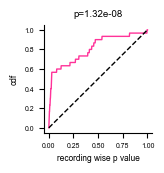

In [35]:
# we do this per-recording
flattened_p = []
for x in p_AE_bs:
    flattened_p.extend(x)
flattened_p = [max(x, 1/n_bootstrap) for x in flattened_p]

# calculate cumulative distribution of p values
p_x = np.linspace(0,1,1000)
p_cdf = np.asarray([np.mean(flattened_p<x) for x in p_x])

fig, ax = plt.subplots(1,1,figsize=(1.4, 1.4))
ax.plot(p_x, p_cdf, color=color_getter(0))
ax.plot((0,1), (0,1), 'k--')

ax.set_xlabel('recording wise p value')
ax.set_ylabel('cdf')
ax.set_title('p={:0.2e}'.format(kstest(flattened_p, uniform.cdf)[1]))
toggle_spines(ax, 0, 1, 0, 1)

plt.savefig('../svg/ed02_e.svg')
plt.show()

## Extended Data Fig. 1h (covariance of neural data with nuisance vairables)
- Compare bump-scene alignment with
    - fish age
    - time of the day
    - raw # of ROIs
    - amount of behavior

In [36]:
# disregard nesting (for the sake of simplicity)
flattened_AE = []
for x in AE:
    flattened_AE.extend(x)

ages = []
hours = []
n_rois = []
n_bouts = []
    
for rec in data:
    for D in rec:
        ages.append(D['metadata']['age'])
        hours.append(D['metadata']['hour'])
        n_rois.append(D['metadata']['n_roi_tot'])
        n_bouts.append(D['metadata']['n_bout_tot'])

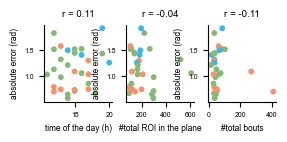

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(3, 1))

ax[0].scatter(hours, flattened_AE, c=ages, s=10, cmap=cc.cm.CET_I1)
ax[0].set_xlabel('time of the day (h)')
ax[0].set_title('r = {:0.2f}'.format(np.corrcoef(hours, flattened_AE)[0,1]))

ax[1].scatter(n_rois, flattened_AE, c=ages, s=10, cmap=cc.cm.CET_I1)
ax[1].set_xlabel('#total ROI in the plane')
ax[1].set_title('r = {:0.2f}'.format(np.corrcoef(n_rois, flattened_AE)[0,1]))

ax[2].scatter(n_bouts, flattened_AE, c=ages, s=10, cmap=cc.cm.CET_I1)
ax[2].set_xlabel('#total bouts')
ax[2].set_title('r = {:0.2f}'.format(np.corrcoef(n_bouts, flattened_AE)[0,1]))

for axx in ax:
    toggle_spines(axx, 0, 1, 0, 1)
    axx.set_ylabel('absolute error (rad)')
    
plt.savefig('../svg/ed01_h.svg')
plt.show()

## Extended Data Fig. 2b (tuning width of individual HD cells)

In [38]:
# prepare bins 
n_tuning_bin = 32
tuning_bin_edges = np.linspace(-np.pi, np.pi, n_tuning_bin+1)
tuning_bin_center = (tuning_bin_edges[:-1] + tuning_bin_edges[1:])/2
upsample_x = np.linspace(-np.pi, np.pi, 360)

In [39]:
indiv_tuning = []
all_R2 = []
for i, fish_data in enumerate(data):
    for j, D in enumerate(fish_data):

        """
        For each recording, for training/test potion of the data, for each ROI,
        we calculate the (centered) tuning curve, upsample it, and calculate
        the fraction above half max as the summary measure of the tuning width
        """
        
        indiv_tuning = []
    
        is_train = split_time(D['t_i'], slog[-2]['t_start'], slog[-2]['duration'], True)
        is_test  = split_time(D['t_i'], slog[-2]['t_start'], slog[-2]['duration'], False)
        
        for y, b in zip(D['traces'], D['fit_param'][:, 1]):
            indiv_tuning.append((
                binned_statistic(angular_diff(D['theta_i'][is_train], b), y[is_train], bins=tuning_bin_edges)[0],
                binned_statistic(angular_diff(D['theta_i'][is_test], b),  y[is_test],  bins=tuning_bin_edges)[0]
            ))
        indiv_tuning = np.asarray(indiv_tuning)
        
        # normalization
        indiv_tuning = (indiv_tuning - np.nanmin(indiv_tuning, axis=2)[:, :, None]) /\
                       (np.nanmax(indiv_tuning, axis=2) - np.nanmin(indiv_tuning, axis=2))[:, :, None]
        D['indiv_tuning'] = indiv_tuning 
        
        # updample and count part above half max as a coarce measurement of the tuning width
        frac_above_half = np.empty((2, indiv_tuning.shape[0]))
        for k, this_it in enumerate(indiv_tuning):
            for l, temp in enumerate(this_it):
                non_nan = np.isnan(temp)==0
                us_tuning = np.interp(upsample_x, tuning_bin_center[non_nan], temp[non_nan])
                frac_above_half[l, k] = np.mean(us_tuning>0.5)
        D['frac_above_half'] = frac_above_half

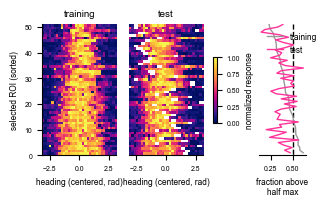

In [40]:
# Look at the same example fish
fid = 1
rid = 1
D = data[fid][rid]

fig, ax = plt.subplots(1, 3, figsize=(3.4,1.7), width_ratios=(2,2,1))

# sort by training set width
sort_ind = np.argsort(D['frac_above_half'][0, :])
n_roi = D['indiv_tuning'].shape[0]

# show individual normalzied tuning as heat maps
for i in range(2):
    im = ax[i].imshow(D['indiv_tuning'][sort_ind, i, :],
                 aspect='auto', vmin=0, vmax=1, cmap=cc.cm.CET_L8, interpolation='none',
                 extent=(-np.pi, np.pi, 0, n_roi))

# plot the summary measure
ax[2].plot([0.5,0.5],[0,n_roi],'k--')
ax[2].plot(D['frac_above_half'][0, sort_ind], np.arange(n_roi), color=color_getter(1), label='training')
ax[2].plot(D['frac_above_half'][1, sort_ind], np.arange(n_roi), color=color_getter(0), label='test')
ax[2].legend()
ax[2].set_ylim(n_roi, 0)

ax[0].set_xlabel('heading (centered, rad)')
ax[1].set_xlabel('heading (centered, rad)')
ax[2].set_xlabel('fraction above\nhalf max')

ax[0].set_ylabel('selected ROI (sorted)')

ax[0].set_title('training')
ax[1].set_title('test')

cb = plt.colorbar(im, ax=ax[:2], location='right', shrink=0.5)
cb.set_label('normalized response')

toggle_spines(ax[0],0,1,0,1)
toggle_spines(ax[1],0,1,0,0)
toggle_spines(ax[2],0,1,0,0)

plt.savefig('../svg/ed02_b.svg')
plt.show()

## Extended Data Fig. 2c (show the distribution of the tuning width for population)

In [41]:
# Do the stacked histogram
n_bin = 20
fah_edges = np.linspace(0, 1, n_bin+1)
fah_center = (fah_edges[:-1] + fah_edges[1:])/2
fah_hist = np.zeros((2, len(data), len(fah_center)))

for i, fish_data in enumerate(data):
    for j, D in enumerate(fish_data):
        fah_hist[0,i,:] += np.histogram(D['frac_above_half'][0, :], bins=fah_edges, density=False)[0]
        fah_hist[1,i,:] += np.histogram(D['frac_above_half'][1, :], bins=fah_edges, density=False)[0]

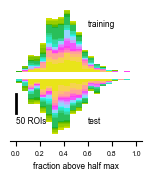

In [43]:
# stacked histogram, where each color correspond to each fish
cum_fah_hist = np.cumsum(fah_hist, axis=1)
fig, ax = plt.subplots(1, 1, figsize=(1.7, 1.7))
for i in range(len(data)):
    ax.bar(fah_center, fah_hist[0, i, :], bottom=cum_fah_hist[0, i, :]-fah_hist[0, i, :]+10, width=1/n_bin, color=cc.cm.CET_C7(i/len(data)))
    ax.bar(fah_center, -fah_hist[1, i, :], bottom=-cum_fah_hist[1, i, :]+fah_hist[1, i, :]-10, width=1/n_bin, color=cc.cm.CET_C7(i/len(data)))
ax.plot([0,0],[-50,-100],'k-',lw=2)
ax.text(0, -130,'50 ROIs')
ax.text(0.6, -130,'test')
ax.text(0.6, +130,'training')
ax.set_xlabel('fraction above half max')
toggle_spines(ax,0,1,0,0)

plt.savefig('../svg/ed02_c.svg')
plt.show()

## Extended Data Fig. 1a (behavioral responses to scene rotation over time)
- Show that fish is doing OMR and not fixating on the sun

In [44]:
mean_snips = []

for i, fish_data in enumerate(data):
    
    this_fish_theta_snips = []
    this_fish_cumftheta_snips = []
    this_fish_extheta_snips = []
    
    for j, D in enumerate(fish_data):
        # find midpoints of exafferent rotations (in time)
        t_start = D['slog'][-2]['t_start']
        duration = D['slog'][-2]['duration']
        olp = D['slog'][-2]['OLperiod']
        old = D['slog'][-2]['OLduration']
        
        rotation_midpoints = [t_start + i*olp + (olp - old/2) for i in range(duration//olp-1)]

        theta_snip, snip_t = cut_snip(D['theta_i'],     D['t_i'], rotation_midpoints, 10, 10, subtract_pre=False)
        cumftheta_snip, _  = cut_snip(D['cumftheta_i'], D['t_i'], rotation_midpoints, 10, 10, subtract_pre=False)
        extheta_snip, _    = cut_snip(D['extheta_i'],   D['t_i'], rotation_midpoints, 10, 10, subtract_pre=False)
        
        theta_snip     -= theta_snip[:, 0][:, None]
        cumftheta_snip -= cumftheta_snip[:, 0][:, None]
        extheta_snip   -= extheta_snip[:, 0][:, None]
        
        # flipping & registering
        this_fish_theta_snips.append(theta_snip * np.sign(extheta_snip[:, -1])[:, None])
        this_fish_cumftheta_snips.append(cumftheta_snip * np.sign(extheta_snip[:, -1])[:, None])
        this_fish_extheta_snips.append(extheta_snip * np.sign(extheta_snip[:, -1])[:, None])
        
    this_fish_theta_snips    = np.vstack(this_fish_theta_snips)
    this_fish_cumftheta_snips = np.vstack(this_fish_cumftheta_snips)
    this_fish_extheta_snips  = np.vstack(this_fish_extheta_snips)
        
    mean_snips.append((np.mean(this_fish_theta_snips, axis=0),
                       np.mean(this_fish_cumftheta_snips, axis=0),
                       np.mean(this_fish_extheta_snips, axis=0),))
mean_snips = np.asarray(mean_snips)

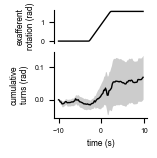

In [45]:
fig, ax = plt.subplots(2, 1, figsize=(1.2, 1.4), height_ratios=(1,2))

mean_turn = np.mean(mean_snips[:, 1, :], axis=0)
sem_turn = np.std(mean_snips[:, 1, :], axis=0)/np.sqrt(mean_snips.shape[0])

ax[0].plot(snip_t, np.mean(mean_snips[:, 2, :], axis=0), color='black')
ax[1].fill_between(snip_t, mean_turn-sem_turn, mean_turn+sem_turn, alpha=0.2, color='black', lw=0)
ax[1].plot(snip_t, mean_turn, color='black')

ax[0].set_ylabel('exafferent\nrotation (rad)')
ax[1].set_ylabel('cumulative\nturns (rad)')
ax[1].set_xlabel('time (s)')

toggle_spines(ax[0], 0,0,0,1)
toggle_spines(ax[1], 0,1,0,1)

plt.savefig('../svg/ed01_a.svg')
plt.show()

## Extended Data Fig. 1b (turn bias as a function of the scene orientation)

In [46]:
bias_theta = []
for i, fish_data in enumerate(data):
    this_fish_bias_theta = []
    for j, D in enumerate(fish_data):
        
        t_start = D['slog'][-2]['t_start']
        t_end = t_start + D['slog'][-2]['duration']

        # pull out bout from closed loop data
        bout_frame = np.where(D['theta_update_spike']==1)[0]
        bout_t = D['t_s'][bout_frame]
        bout_bias = D['fish_theta'][bout_frame]
        
        bias_stim_on = bout_bias[(bout_t>t_start)*(bout_t<t_end)]
        
        # get theta
        bout_frame_i = np.asarray([np.argmax(D['t_i']>tt) for tt in bout_t if tt>t_start and tt<t_end])
        theta_at_bout = D['theta_i'][bout_frame_i]
        this_fish_bias_theta.append(np.vstack((bias_stim_on, theta_at_bout)))
    bias_theta.append(np.hstack(this_fish_bias_theta))

In [47]:
# Calculate binned average (by scene orientation)

be = np.linspace(-np.pi,np.pi,13) # bin edge
bc = (be[1:]+be[:-1])/2 # bin center

mean_bias_by_theta =  np.asarray([binned_statistic(angular_diff(bt[1,:],0),bt[0,:],bins=be)[0] for bt in bias_theta])
mean_mbbt = np.nanmean(mean_bias_by_theta, axis=0)
sem_mbbt = np.nanstd(mean_bias_by_theta, axis=0) / np.sqrt(len(data))

theta_hist = np.asarray(
    [np.histogram(angular_diff(bt[1,:],0), bins=be, density=True)[0] for bt in bias_theta]
)
bias_hist = np.asarray(
    [np.histogram(bt[0,:], bins=np.linspace(-5,5,20), density=True)[0] for bt in bias_theta]
)

mean_th = np.nanmean(theta_hist,axis=0)
sem_th = np.nanstd(theta_hist,axis=0)/np.sqrt(len(data))
mean_bh = np.nanmean(bias_hist,axis=0)
sem_bh = np.nanstd(bias_hist,axis=0)/np.sqrt(len(data))

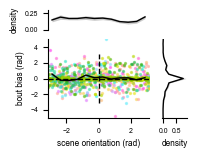

In [48]:
fig, ax = plt.subplots(2, 2, width_ratios=(4,1), height_ratios=(1,4), figsize=(1.8, 1.4))

# scatter plot of bout bias (each color = each fish)
for i, this_btpair in enumerate(bias_theta):
    ax[1, 0].scatter(angular_diff(this_btpair[1, :],0), this_btpair[0, :], s=2, alpha=0.5, color=cc.cm.CET_C7(i/len(data)))

ax[1, 0].fill_between(bc, mean_mbbt-sem_mbbt, mean_mbbt+sem_mbbt, color=(0,0,0), alpha=0.2, lw=0)
ax[1, 0].plot(bc, mean_mbbt, color=(0,0,0))
ax[1, 0].plot((-np.pi,np.pi),(0,0),'k--',zorder=3)
ax[1, 0].plot((0,0),(-np.pi,np.pi),'k--',zorder=3)

ax[0, 0].fill_between(bc, mean_th-sem_th, mean_th+sem_th, alpha=0.2, color='black', lw=0)
ax[0, 0].plot(bc, mean_th, color='black')
ax[0, 0].set_ylim(0,0.3)

ax[1, 1].fill_betweenx(np.linspace(-5,5,19), mean_bh-sem_bh, mean_bh+sem_bh, alpha=0.2, color='black', lw=0)
ax[1, 1].plot(mean_bh, np.linspace(-5,5,19), color='black')

for i in range(2):
    ax[i, 0].set_xlim(-np.pi, np.pi)
    ax[1, i].set_ylim(-5, 5)

ax[0, 0].set_ylabel('density')
ax[1, 0].set_ylabel('bout bias (rad)')
ax[1, 0].set_xlabel('scene orientation (rad)')
ax[1, 1].set_xlabel('density')
    
toggle_spines(ax[0,0], 0, 0, 0, 1)
toggle_spines(ax[1,0], 0, 1, 0, 1)
toggle_spines(ax[0,1], 0, 0, 0, 0)
toggle_spines(ax[1,1], 0, 1, 0, 0)

plt.savefig('../svg/ed01_b.svg')
plt.show()